This notebook provides examples of visaluzing the weight magnitude and activation statistics in the model before and after matching.

In [3]:
import sys
sys.path.append("..")

In [9]:
import torch
import torch.nn as nn
from source.utils.utils import load_model
from source.utils.data_funcs import load_data
from source.utils.weight_matching import weight_matching
from source.utils.activation_matching import activation_matching
from source.utils.connect import interpolate_state_dicts, repair
from source.utils.logger import Logger
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [5]:
class config:
    model = 'cifar_vgg16'
    dataset = 'cifar10'
    special_init = 'vgg_init' # 'vgg_init' (kaiming init) or None (uniform init)
    print_freq = 100
    data_dir = '../../Linear_Mode_Connectivity/data'
    n = 3 # number of interpolation points

In [6]:
# necessary to create logger if using the train/validate/eval_line etc. functions
Logger.setup_logging()
logger = Logger()

trainset, testset = load_data(config.data_dir, config.dataset)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=256, shuffle=False)

trainset_noaug, _ = load_data(config.data_dir, config.dataset, no_random_aug=True)
trainloader_noaug = DataLoader(trainset_noaug, batch_size=128, shuffle=True)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.CrossEntropyLoss()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [7]:
sd_1 = torch.load(f'../../Linear_Mode_Connectivity/same_init_ex/{config.dataset}/{config.model}/diff_init/seed_20/model_1_160.pt', map_location=device)
sd_2 = torch.load(f'../../Linear_Mode_Connectivity/same_init_ex/{config.dataset}/{config.model}/diff_init/seed_20/model_2_160.pt', map_location=device)
sd_init = torch.load(f'../../Linear_Mode_Connectivity/same_init_ex/{config.dataset}/{config.model}/diff_init/seed_20/model_1_0.pt', map_location=device)

model_1 = load_model(config).to(device)
model_2 = load_model(config).to(device)
model_init = load_model(config).to(device)
model_1.load_state_dict(sd_1)
model_2.load_state_dict(sd_2)
model_init.load_state_dict(sd_init)

<All keys matched successfully>

In [ ]:
sd_2_wm, _ = weight_matching(config.model, sd_1, sd_2, device=device)
sd_2_am, _ = activation_matching(config.model, model_1, model_2, trainloader, 100, device)

model_2_wm = load_model(config).to(device)
model_2_wm.load_state_dict(sd_2_wm)
model_2_am = load_model(config).to(device)
model_2_am.load_state_dict(sd_2_am)

In [10]:
sd_mid = interpolate_state_dicts(sd_1, sd_2, 0.5)
sd_wm_mid = interpolate_state_dicts(sd_1, sd_2_wm, 0.5)
sd_am_mid = interpolate_state_dicts(sd_1, sd_2_am, 0.5)

model_mid = load_model(config).to(device)
model_wm_mid = load_model(config).to(device)
model_am_mid = load_model(config).to(device)

model_mid.load_state_dict(sd_mid)
model_wm_mid.load_state_dict(sd_wm_mid)
model_am_mid.load_state_dict(sd_am_mid)

<All keys matched successfully>

In [11]:
record_name = []
if 'vgg' in config.model: 
    for name, m in model_1.named_modules():
        if isinstance(m, nn.ReLU):
            record_name.append(name)
    record_name.append('classifier.0')

elif 'resnet' in config.model:
    for name, m in model_1.named_modules():
        if isinstance(m, nn.ReLU):
            record_name.append(name)
    record_name.append('fc')

In [12]:
model_mid_rescaled = repair(trainloader, [model_1, model_2], model_mid, device, variant='rescale', name=config.model)
model_mid_repaired = repair(trainloader, [model_1, model_2], model_mid, device, variant='repair', name=config.model)

model_wm_mid_rescaled = repair(trainloader, [model_1, model_2_wm], model_wm_mid, device, variant='rescale', name=config.model)
model_wm_mid_repaired = repair(trainloader, [model_1, model_2_wm], model_wm_mid, device, variant='repair', name=config.model)

model_am_mid_rescaled = repair(trainloader, [model_1, model_2_am], model_am_mid, device, variant='rescale', name=config.model)
model_am_mid_repaired = repair(trainloader, [model_1, model_2_am], model_am_mid, device, variant='repair', name=config.model)

In [13]:
def record_act(model_s, loader, record_name, device, pre_act=False):
    act_s = []
    for model in model_s:
        model.record(record_name, pre_act=pre_act)
    
    for id_batch, (data, _) in enumerate(loader):
        data = data.to(device)
        for model in model_s:
            model(data)
            act_s.append(model.selected_out)
        break

    for model in model_s:
        model.stop_record()
    return act_s

In [14]:
model_s = [model_1, model_2, model_mid, model_mid_repaired, model_mid_rescaled, model_wm_mid, model_wm_mid_repaired, model_wm_mid_rescaled, model_am_mid, model_am_mid_repaired, model_am_mid_rescaled, model_init]
post_act_s = record_act(model_s, trainloader, record_name, device, pre_act=False)
pre_act_s = record_act(model_s, trainloader, record_name, device, pre_act=True)

In [15]:
type_s = ['end_1', 'end_2', 'mid', 'mid_repaired', 'mid_rescaled', 'wm_mid', 'wm_mid_repaired', 'wm_mid_rescaled', 'am_mid', 'am_mid_repaired', 'am_mid_rescaled', 'init']
type_to_idx = {type_s[i]:i for i in range(len(type_s))}

In [16]:
num_model = len(model_s)
pre_act_ave_scale_s = [list() for _ in range(num_model)]
post_act_ave_scale_s = [list() for _ in range(num_model)]
pre_act_ave_std_s = [list() for _ in range(num_model)]
post_act_ave_std_s = [list() for _ in range(num_model)]

for i in range(num_model):
    for name in pre_act_s[i]:
        linear_name = 'classifier.0' if 'vgg' in config.model else 'fc'
        dim = (2, 3) if name != linear_name else (1)
        pre_act_ave_scale_s[i].append(pre_act_s[i][name].abs().mean().item())
        post_act_ave_scale_s[i].append(post_act_s[i][name].abs().mean().item())
        pre_act_ave_std_s[i].append(pre_act_s[i][name].std(dim=dim).mean().item())
        post_act_ave_std_s[i].append(post_act_s[i][name].std(dim=dim).mean().item())

Text(0.5, 1.0, 'Average Scale of Post-Activations')

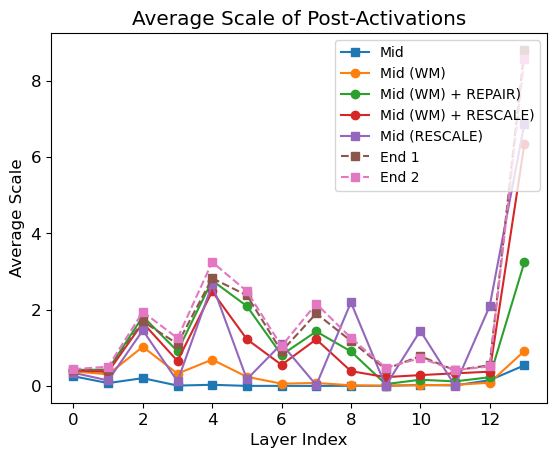

In [21]:
plt.rcParams.update({'font.size': 12})

wm = 'wm'
pre = 'post' # pre post
scale = 'scale' # scale std

cur_res = eval(f'{pre}_act_ave_{scale}_s')
save_name = f'{wm}_{pre}_{scale}'


plt.plot(cur_res[type_to_idx['mid']], label='Mid', marker='s')
plt.plot(cur_res[type_to_idx[f'{wm}_mid']], label=f'Mid ({wm.upper()})', marker='o')
plt.plot(cur_res[type_to_idx[f'{wm}_mid_repaired']], label=f'Mid ({wm.upper()}) + REPAIR)', marker='o')
plt.plot(cur_res[type_to_idx[f'{wm}_mid_rescaled']], label=f'Mid ({wm.upper()}) + RESCALE)', marker='o')
plt.plot(cur_res[type_to_idx['mid_rescaled']], label='Mid (RESCALE)', marker='s')
plt.plot(cur_res[type_to_idx['end_1']], label='End 1', marker='s', linestyle='--')
plt.plot(cur_res[type_to_idx['end_2']], label='End 2', marker='s', linestyle='--')


plt.ylabel(f'Average {scale.capitalize()}')
plt.xlabel('Layer Index')
# legend size 
plt.legend(loc='upper right', prop={'size': 10})
plt.title(f'Average {scale.capitalize()} of {pre.capitalize()}-Activations')

Compared with random initialization

Text(0.5, 1.0, 'Average Scale of Post-Activations')

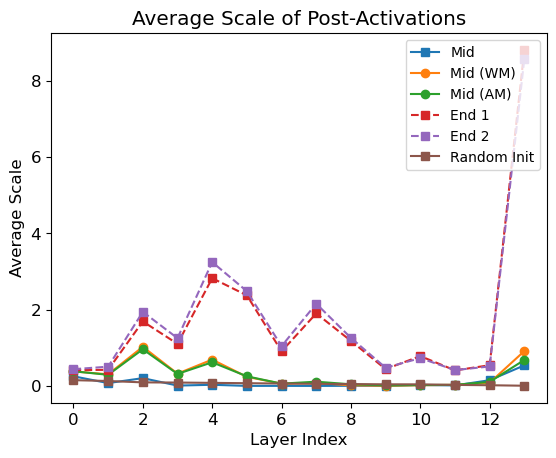

In [22]:
plt.rcParams.update({'font.size': 12})

pre = 'post' # pre post
scale = 'scale' # scale std

cur_res = eval(f'{pre}_act_ave_{scale}_s')
save_name = f'init_{pre}_{scale}'


plt.plot(cur_res[type_to_idx['mid']], label='Mid', marker='s')
plt.plot(cur_res[type_to_idx['wm_mid']], label='Mid (WM)', marker='o')
plt.plot(cur_res[type_to_idx['am_mid']], label='Mid (AM)', marker='o')
plt.plot(cur_res[type_to_idx['end_1']], label='End 1', marker='s', linestyle='--')
plt.plot(cur_res[type_to_idx['end_2']], label='End 2', marker='s', linestyle='--')
plt.plot(cur_res[type_to_idx['init']], label='Random Init', marker='s')


plt.ylabel(f'Average {scale.capitalize()}')
plt.xlabel('Layer Index')
# legend size 
plt.legend(loc='upper right', prop={'size': 10})
plt.title(f'Average {scale.capitalize()} of {pre.capitalize()}-Activations')

Weight magnitude

In [19]:
w_abs_mean_ori = []
w_abs_mean_wm= []
w_abs_mean_am= []
w_abs_mean_end = []
for k in sd_1:
    if 'weight' in k:
        w_abs_mean_ori.append(sd_mid[k].abs().mean().item())
        w_abs_mean_wm.append(sd_wm_mid[k].abs().mWean().item())
        w_abs_mean_am.append(sd_am_mid[k].abs().mean().item())
        w_abs_mean_end.append(sd_1[k].abs().mean().item())
    if 'bias' in k:
        w_abs_mean_ori[-1] = (w_abs_mean_ori[-1] + sd_mid[k].abs().mean().item())/2
        w_abs_mean_wm[-1] = (w_abs_mean_wm[-1] + sd_wm_mid[k].abs().mean().item())/2
        w_abs_mean_am[-1] = (w_abs_mean_am[-1] + sd_am_mid[k].abs().mean().item())/2
        w_abs_mean_end[-1] = (w_abs_mean_end[-1] + sd_1[k].abs().mean().item())/2

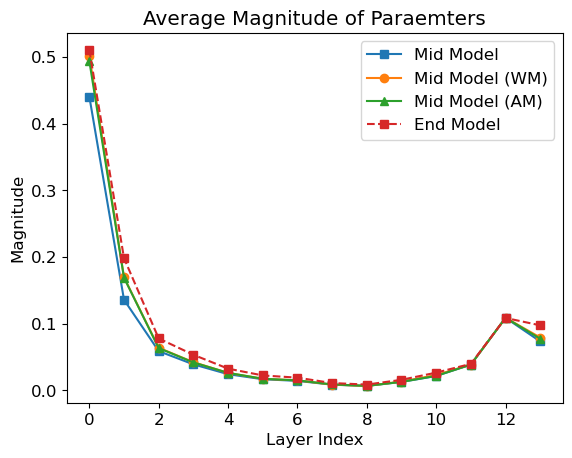

In [20]:
plt.rcParams.update({'font.size': 12})

plt.plot(w_abs_mean_ori, label='Mid Model', marker='s')
plt.plot(w_abs_mean_wm, label='Mid Model (WM)', marker='o')
plt.plot(w_abs_mean_am, label='Mid Model (AM)', marker='^')
plt.plot(w_abs_mean_end, label='End Model', marker='s', linestyle='--')
plt.ylabel('Magnitude')
plt.xlabel('Layer Index')
plt.title('Average Magnitude of Paraemters')
plt.legend()

Number of zero activations

In [23]:
ave_zeros_1 = []
ave_zeros_mid = []
ave_zeros_wm_mid = []
ave_zeros_am_mid = []
ave_zeros_init = []

cur_res = post_act_s

linear_name = 'classifier.0' if 'vgg' in config.model else 'fc'

total_s = []
for k, v in cur_res[0].items():
    if k == linear_name:
        break
    total_s.append(v.shape[1] * v.shape[2] * v.shape[3])

for name in post_act_s[0]:
    if name == linear_name:
        break
    ave_zeros_1.append((cur_res[type_to_idx['end_1']][name]==0).sum(dim=(1, 2, 3)).float().mean().item() / total_s[record_name.index(name)])
    ave_zeros_mid.append((cur_res[type_to_idx['mid']][name]==0).sum(dim=(1, 2, 3)).float().mean().item() / total_s[record_name.index(name)])
    ave_zeros_wm_mid.append((cur_res[type_to_idx['wm_mid']][name]==0).sum(dim=(1, 2, 3)).float().mean().item() / total_s[record_name.index(name)])
    ave_zeros_am_mid.append((cur_res[type_to_idx['am_mid']][name]==0).sum(dim=(1, 2, 3)).float().mean().item() / total_s[record_name.index(name)])
    ave_zeros_init.append((cur_res[type_to_idx['init']][name]==0).sum(dim=(1, 2, 3)).float().mean().item() / total_s[record_name.index(name)])

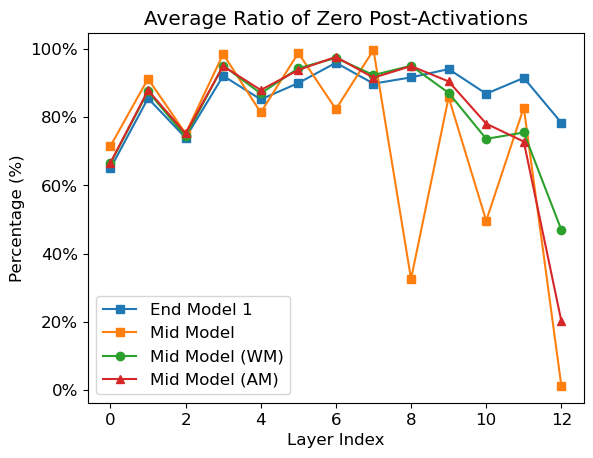

In [24]:
plt.rcParams.update({'font.size': 12})

plt.plot(ave_zeros_1, label='End Model 1', marker='s')
plt.plot(ave_zeros_mid, label='Mid Model', marker='s')
plt.plot(ave_zeros_wm_mid, label='Mid Model (WM)', marker='o')
plt.plot(ave_zeros_am_mid, label='Mid Model (AM)', marker='^')
# plt.plot(ave_zeros_init, label='Random Init', marker='s', linestyle='--')
plt.ylabel('Percentage (%)')
plt.yticks(ticks=[0, 0.2, 0.4, 0.6, 0.8, 1], labels=['0%', '20%', '40%', '60%', '80%', '100%'])
plt.xlabel('Layer Index')
plt.title('Average Ratio of Zero Post-Activations')
plt.legend()